In [1]:
# import the packages
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gym
import numpy as np
from gym.wrappers import FilterObservation, FlattenObservation
import time
from tqdm import tqdm

In [2]:
# check and use GPU if available if not use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# learn about the environment - FetchReach-v1 is OpenAI Gym enivironment
env = gym.make('FetchReach-v1')
env.reset()

# run the agent for 200 iterations in the environment
for i in range(200):
    # do not use env.render() with jupyter notebook
    # env.render() 
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    if done:
        env.reset()
        
env.close()

/opt/anaconda3/envs/RL/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
# function to unpack observation from gym environment
def unpackObs(obs):
    return  obs['achieved_goal'], \
            obs['desired_goal'],\
            np.concatenate((obs['observation'], \
            obs['desired_goal'])), \
            np.concatenate((obs['observation'], \
            obs['achieved_goal']))

In [5]:
# check and test
unpackObs(env.reset())
assert(len(unpackObs(env.reset())) == 4)

(array([1.34183265, 0.74910039, 0.53472272]),
 array([1.36300866, 0.7185999 , 0.51375569]),
 array([ 1.34183265e+00,  7.49100387e-01,  5.34722720e-01,  1.97805133e-04,
         7.15193042e-05,  7.73933014e-06,  5.51992816e-08, -2.42927453e-06,
         4.73325650e-06, -2.28455228e-06,  1.36300866e+00,  7.18599903e-01,
         5.13755691e-01]),
 array([ 1.34183265e+00,  7.49100387e-01,  5.34722720e-01,  1.97805133e-04,
         7.15193042e-05,  7.73933014e-06,  5.51992816e-08, -2.42927453e-06,
         4.73325650e-06, -2.28455228e-06,  1.34183265e+00,  7.49100387e-01,
         5.34722720e-01]))

In [6]:
# replay buffer

# create replay buffer of tuples of (state, next_state, action, reward, done)
class ReplayBuffer():
    def __init__(self, max_size=1e6):
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def add(self, data):
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] = data
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(data)

    def sample(self, batch_size):
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        x, y, u, r, d = [], [], [], [], []

        for i in ind: 
            X, Y, U, R, D = self.storage[i]
            x.append(np.array(X, copy=False))
            y.append(np.array(Y, copy=False))
            u.append(np.array(U, copy=False))
            r.append(np.array(R, copy=False))
            d.append(np.array(D, copy=False))

        return np.array(x), np.array(y), np.array(u), np.array(r).reshape(-1,1), np.array(d).reshape(-1,1)

### DDPG Architecture

The deterministic policy gradients are used to train the actor network. DDPG is off-policy and combines some methods used for Deep Q Networks (DQN) like target network updating and an experience replay buffer. Unlike DQN, DDPG can be used in the continuous action space. In this example, we train a DDPG network on continuous Lunar Lander.

In [21]:
# Creat Actor NN
class ActorNet(nn.Module):
    def __init__(self, state_size, action_size, hidden_size, action_max):
        super(ActorNet, self).__init__()
        self.input_layer = nn.LayerNorm(state_size)
        self.dense_layer_1 = nn.Linear(state_size, hidden_size)
        self.dense_layer_1n = nn.LayerNorm(hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.dense_layer_2n = nn.LayerNorm(hidden_size)
        self.output = nn.Linear(hidden_size, action_size)
        
#         nn.init.uniform_(self.dense_layer_1.weight)
#         nn.init.uniform_(self.dense_layer_2.weight)
        nn.init.uniform_(self.output.weight,-0.003,0.003)
        
        self.action_max = action_max
     
    
    def forward(self, x):
#         x = torch.clamp(x,-1.0,1.0)
        x = self.input_layer(x)
        x = F.relu(self.dense_layer_1n(self.dense_layer_1(x)))
        x = F.relu(self.dense_layer_2n(self.dense_layer_2(x)))
        return torch.tanh(self.output(x)) * self.action_max

# create ctitic NN
class CriticNet(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(CriticNet, self).__init__()
        self.input_layer = nn.LayerNorm(state_size+action_size)
        self.dense_layer_1 = nn.Linear(state_size+action_size, hidden_size)
        self.dense_layer_1n = nn.LayerNorm(hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.dense_layer_2n = nn.LayerNorm(hidden_size)
        self.output = nn.Linear(hidden_size, 1)
        
#         nn.init.uniform_(self.dense_layer_1.weight)
#         nn.init.uniform_(self.dense_layer_2.weight)
        nn.init.uniform_(self.output.weight,-0.003,0.003)
        

    def forward(self, x, a):
#         x = torch.clamp(x,-1.0,1.0)
        x = self.input_layer(torch.cat((x,a),dim=1))
        x = F.relu(self.dense_layer_1n(self.dense_layer_1(x)))
        x = F.relu(self.dense_layer_2n(self.dense_layer_2(x)))
        return self.output(x)

In [22]:
# create DDPG Class

class DDPGAgent():
    def __init__(self, state_size, action_size, hidden_size, actor_lr, critic_lr, discount,
                 min_action, max_action, exploration_noise):
        self.action_size = action_size
        self.actor = ActorNet(state_size, action_size, hidden_size, max_action).to(device)
        self.actor_target = ActorNet(state_size, action_size, hidden_size, max_action).to(device)
        
        self.critic = CriticNet(state_size, action_size, hidden_size).to(device)
        self.critic_target = CriticNet(state_size, action_size, hidden_size).to(device)
        
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_target.load_state_dict(self.critic.state_dict())
        
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.discount = discount
        self.min_action = min_action
        self.max_action = max_action
        self.exploration_noise = exploration_noise
        
    def select_action(self, state):
        #get action probs then randomly sample from the probabilities
        with torch.no_grad():
            input_state = torch.FloatTensor(state).to(device)
            action = self.actor(input_state)
            #detach and turn to numpy to use with np.random.choice()
            action = action.detach().cpu().numpy()
            #in DDPG add noise for exploration
            action = (action + np.random.normal(0., self.exploration_noise, 
                       size=self.action_size)).clip(self.min_action, self.max_action)   
        return action

    
    def train(self, replay_buffer, batch_size):
        # sample a batch from the replay buffer
        x0, x1, a, r, d = replay_buffer.sample(batch_size)
        # turn batches into tensors and use GPU if available
        state_batch = torch.FloatTensor(x0).to(device)
        next_state_batch = torch.FloatTensor(x1).to(device)
        action_batch = torch.FloatTensor(a).to(device)
        reward_batch = torch.FloatTensor(r).to(device)
        flipped_done_batch = torch.FloatTensor(d).to(device) #already flipped done when adding to replay buffer

        # get target net target values
        with torch.no_grad():
            target_action = self.actor_target(next_state_batch).view(batch_size,-1)
            target_v = reward_batch + flipped_done_batch*self.discount*self.critic_target(next_state_batch, 
                                                                           target_action).view(batch_size,-1)
        # get train net values for updating the critic network    
        critic_v = self.critic(state_batch, action_batch).view(batch_size,-1)
        
        # train critic
        critic_loss = nn.MSELoss()(critic_v, target_v)
#         critic_loss = F.smooth_l1_loss(critic_v, target_v)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step() 
        
        # train actor
        train_action = self.actor(state_batch)
        actor_loss = -torch.mean(self.critic(state_batch,train_action))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step() 
        
        return actor_loss.detach().cpu().numpy(), critic_loss.detach().cpu().numpy()
        
        
    def update_target_network_soft(self, update_tau=0.001):
        # soft target network update: update target networks with mixture of train and target
        for target_var, var in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_var.data.copy_((1.-update_tau) * target_var.data + (update_tau) * var.data)
            
        for target_var, var in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_var.data.copy_((1.-update_tau) * target_var.data + (update_tau) * var.data)

In [23]:
# Initialize env and set up hyperparameters
env = gym.make('FetchReach-v1')
env = FlattenObservation(FilterObservation(env, ['desired_goal','observation']))
# obs = unpackObs(env.reset())
action_size = env.action_space.shape[0]
state_size = env.observation_space.shape[0]
min_action = env.action_space.low[0]
max_action = env.action_space.high[0]
env.close()

env = gym.make('FetchReach-v1')

# set seed
seed = 31
env.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
# create replay buffer
replay_size = 1000000 # size of replay buffer
replay_buffer = ReplayBuffer(max_size=replay_size)    

# target update hyperparameters
# start_training_after = 50 # start training NN after this many timesteps
# update_target_every = 1 # update target network every this steps
tau = 0.001
episodes = 500   
discount = 0.99
batch_size = 64
exploration_noise = 0.0
hidden_size = 256
actor_lr = 0.0001
critic_lr = 0.001
reward_scale = 1

# create DDPG Agent
agent = DDPGAgent(state_size=state_size, action_size=action_size, hidden_size=hidden_size, 
                  actor_lr=actor_lr, critic_lr=critic_lr, discount=discount, min_action=min_action,
                  max_action=max_action, exploration_noise=exploration_noise)

### The RL Training Loop

In the loop, we iterate through our episodes and then the timesteps within the episodes. We stop training the agent based on some stopping condition like a max episode value, a max timestep value, or if the agent's performance reaches a certain level.

In each episode and at each timestep the agent selects an action, calls env.step(), and stores the sample in the replay buffer. The agent will also train the training neural network and periodically update the target network. When an episode is done the env is reset.

In [24]:
stats_rewards_list = [] # store stats for plotting in this
# stats_every = 10 # print stats every this many episodes
total_reward = 0
timesteps = 0
episode_length = 0
stats_actor_loss, stats_critic_loss = [], []

t1 = time.time()
for ep in tqdm(range(episodes)):
    
    achieved_g,desired_g,state,state_prime = unpackObs(env.reset())

    # train in each episode until episode is done
    while True:
        timesteps += 1
        episode_length += 1
        #env.render()
        # select an action from the agent's policy
        action = agent.select_action(state)
        # enter action into the env
        observation, reward, done, info = env.step(action)
        total_reward += reward
        
        achieved_g,desired_g,next_state,next_state_prime = unpackObs(observation)
        # add experience to replay buffer
        replay_buffer.add((state, next_state, action, reward*reward_scale,1-float(done)))
        
        # HER experience
#         substitute_g = achieved_g.copy()
#         substitute_reward = env.compute_reward(achieved_g, substitute_g, info)
#         replay_buffer.add((state_prime, next_state_prime, action, substitute_reward*reward_scale,0))
        
        
        # train the agent
        if len(replay_buffer.storage) > batch_size:
            actor_loss, critic_loss = agent.train(replay_buffer, batch_size)
            stats_actor_loss.append(actor_loss) 
            stats_critic_loss.append(critic_loss) 
            agent.update_target_network_soft()

            
        if done:
            stats_rewards_list.append((ep, total_reward, episode_length))
             
    
            print('Episode: {}'.format(ep),
                'Timestep: {}'.format(timesteps),
                'Total reward: {:.1f}'.format(total_reward),
                'Episode length: {:.1f}'.format(episode_length),
                'Actor Loss: {:.4f}'.format(np.mean(stats_actor_loss)), 
                'Critic Loss: {:.4f}'.format(np.mean(stats_critic_loss)))
            stats_actor_loss, stats_critic_loss = [], []
            total_reward = 0
            episode_length = 0 
            break
        
        state = next_state

t2 = time.time()

  0%|          | 1/500 [00:00<02:21,  3.54it/s]

Episode: 0 Timestep: 50 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.4911 Critic Loss: 0.2685


  0%|          | 2/500 [00:00<03:07,  2.66it/s]

Episode: 1 Timestep: 100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.4591 Critic Loss: 0.2076


  1%|          | 3/500 [00:01<03:38,  2.27it/s]

Episode: 2 Timestep: 150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.2774 Critic Loss: 0.0665


  1%|          | 4/500 [00:02<04:02,  2.04it/s]

Episode: 3 Timestep: 200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.1912 Critic Loss: 0.0097


  1%|          | 5/500 [00:02<04:18,  1.91it/s]

Episode: 4 Timestep: 250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.2327 Critic Loss: 0.0050


  1%|          | 6/500 [00:03<04:32,  1.81it/s]

Episode: 5 Timestep: 300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.3150 Critic Loss: 0.0123


  1%|▏         | 7/500 [00:03<04:49,  1.70it/s]

Episode: 6 Timestep: 350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.3892 Critic Loss: 0.0342


  2%|▏         | 8/500 [00:04<04:55,  1.67it/s]

Episode: 7 Timestep: 400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.3105 Critic Loss: 0.0277


  2%|▏         | 9/500 [00:05<05:03,  1.62it/s]

Episode: 8 Timestep: 450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.2635 Critic Loss: 0.0066


  2%|▏         | 10/500 [00:05<05:12,  1.57it/s]

Episode: 9 Timestep: 500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.3065 Critic Loss: 0.0056


  2%|▏         | 11/500 [00:06<05:14,  1.56it/s]

Episode: 10 Timestep: 550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.3919 Critic Loss: 0.0266


  2%|▏         | 12/500 [00:07<05:17,  1.54it/s]

Episode: 11 Timestep: 600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.3814 Critic Loss: 0.0094


  3%|▎         | 13/500 [00:07<05:19,  1.52it/s]

Episode: 12 Timestep: 650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.3951 Critic Loss: 0.0073


  3%|▎         | 14/500 [00:08<05:24,  1.50it/s]

Episode: 13 Timestep: 700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.4364 Critic Loss: 0.0053


  3%|▎         | 15/500 [00:09<05:41,  1.42it/s]

Episode: 14 Timestep: 750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.4734 Critic Loss: 0.0158


  3%|▎         | 16/500 [00:10<05:36,  1.44it/s]

Episode: 15 Timestep: 800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.3939 Critic Loss: 0.0114


  3%|▎         | 17/500 [00:10<05:32,  1.45it/s]

Episode: 16 Timestep: 850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.3548 Critic Loss: 0.0108


  4%|▎         | 18/500 [00:11<05:28,  1.47it/s]

Episode: 17 Timestep: 900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.3863 Critic Loss: 0.0090


  4%|▍         | 19/500 [00:12<05:26,  1.47it/s]

Episode: 18 Timestep: 950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.4134 Critic Loss: 0.0094


  4%|▍         | 20/500 [00:12<05:23,  1.48it/s]

Episode: 19 Timestep: 1000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.4044 Critic Loss: 0.0079


  4%|▍         | 21/500 [00:13<05:22,  1.49it/s]

Episode: 20 Timestep: 1050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.5106 Critic Loss: 0.0094


  4%|▍         | 22/500 [00:14<05:27,  1.46it/s]

Episode: 21 Timestep: 1100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.5441 Critic Loss: 0.0072


  5%|▍         | 23/500 [00:14<05:24,  1.47it/s]

Episode: 22 Timestep: 1150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.5444 Critic Loss: 0.0082


  5%|▍         | 24/500 [00:15<05:36,  1.41it/s]

Episode: 23 Timestep: 1200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.5864 Critic Loss: 0.0081


  5%|▌         | 25/500 [00:16<05:33,  1.43it/s]

Episode: 24 Timestep: 1250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.6040 Critic Loss: 0.0093


  5%|▌         | 26/500 [00:16<05:36,  1.41it/s]

Episode: 25 Timestep: 1300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.5888 Critic Loss: 0.0127


  5%|▌         | 27/500 [00:17<05:49,  1.35it/s]

Episode: 26 Timestep: 1350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.6257 Critic Loss: 0.0129


  6%|▌         | 28/500 [00:18<05:49,  1.35it/s]

Episode: 27 Timestep: 1400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.5900 Critic Loss: 0.0113


  6%|▌         | 29/500 [00:19<06:06,  1.28it/s]

Episode: 28 Timestep: 1450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.6471 Critic Loss: 0.0159


  6%|▌         | 30/500 [00:20<06:03,  1.29it/s]

Episode: 29 Timestep: 1500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.6928 Critic Loss: 0.0143


  6%|▌         | 31/500 [00:20<05:59,  1.30it/s]

Episode: 30 Timestep: 1550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.6415 Critic Loss: 0.0194


  6%|▋         | 32/500 [00:21<06:19,  1.23it/s]

Episode: 31 Timestep: 1600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.6003 Critic Loss: 0.0170


  7%|▋         | 33/500 [00:22<06:19,  1.23it/s]

Episode: 32 Timestep: 1650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.6486 Critic Loss: 0.0139


  7%|▋         | 34/500 [00:23<06:09,  1.26it/s]

Episode: 33 Timestep: 1700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.6383 Critic Loss: 0.0145


  7%|▋         | 35/500 [00:24<06:21,  1.22it/s]

Episode: 34 Timestep: 1750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.7315 Critic Loss: 0.0168


  7%|▋         | 36/500 [00:25<06:08,  1.26it/s]

Episode: 35 Timestep: 1800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.6885 Critic Loss: 0.0153


  7%|▋         | 37/500 [00:25<06:05,  1.27it/s]

Episode: 36 Timestep: 1850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.6652 Critic Loss: 0.0158


  8%|▊         | 38/500 [00:26<06:06,  1.26it/s]

Episode: 37 Timestep: 1900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.6296 Critic Loss: 0.0150


  8%|▊         | 39/500 [00:27<05:55,  1.30it/s]

Episode: 38 Timestep: 1950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.6098 Critic Loss: 0.0182


  8%|▊         | 40/500 [00:28<05:50,  1.31it/s]

Episode: 39 Timestep: 2000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.5407 Critic Loss: 0.0149


  8%|▊         | 41/500 [00:28<05:46,  1.32it/s]

Episode: 40 Timestep: 2050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.5253 Critic Loss: 0.0247


  8%|▊         | 42/500 [00:29<05:44,  1.33it/s]

Episode: 41 Timestep: 2100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.4982 Critic Loss: 0.0231


  9%|▊         | 43/500 [00:30<05:38,  1.35it/s]

Episode: 42 Timestep: 2150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.5176 Critic Loss: 0.0245


  9%|▉         | 44/500 [00:30<05:34,  1.36it/s]

Episode: 43 Timestep: 2200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.5104 Critic Loss: 0.0216


  9%|▉         | 45/500 [00:31<05:29,  1.38it/s]

Episode: 44 Timestep: 2250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.4691 Critic Loss: 0.0206


  9%|▉         | 46/500 [00:32<05:22,  1.41it/s]

Episode: 45 Timestep: 2300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.5423 Critic Loss: 0.0273


  9%|▉         | 47/500 [00:33<05:13,  1.44it/s]

Episode: 46 Timestep: 2350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.4817 Critic Loss: 0.0301


 10%|▉         | 48/500 [00:33<05:08,  1.47it/s]

Episode: 47 Timestep: 2400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.4019 Critic Loss: 0.0326


 10%|▉         | 49/500 [00:34<05:06,  1.47it/s]

Episode: 48 Timestep: 2450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.3527 Critic Loss: 0.0239


 10%|█         | 50/500 [00:34<05:01,  1.49it/s]

Episode: 49 Timestep: 2500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.3997 Critic Loss: 0.0292


 10%|█         | 51/500 [00:35<04:57,  1.51it/s]

Episode: 50 Timestep: 2550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.5194 Critic Loss: 0.0268


 10%|█         | 52/500 [00:36<04:52,  1.53it/s]

Episode: 51 Timestep: 2600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.4798 Critic Loss: 0.0254


 11%|█         | 53/500 [00:36<04:48,  1.55it/s]

Episode: 52 Timestep: 2650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.4402 Critic Loss: 0.0338


 11%|█         | 54/500 [00:37<04:46,  1.56it/s]

Episode: 53 Timestep: 2700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.4736 Critic Loss: 0.0332


 11%|█         | 55/500 [00:38<04:42,  1.57it/s]

Episode: 54 Timestep: 2750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.4730 Critic Loss: 0.0356


 11%|█         | 56/500 [00:38<04:42,  1.57it/s]

Episode: 55 Timestep: 2800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.4794 Critic Loss: 0.0316


 11%|█▏        | 57/500 [00:39<04:49,  1.53it/s]

Episode: 56 Timestep: 2850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.4811 Critic Loss: 0.0316


 12%|█▏        | 58/500 [00:40<04:46,  1.54it/s]

Episode: 57 Timestep: 2900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.5679 Critic Loss: 0.0280


 12%|█▏        | 59/500 [00:40<04:44,  1.55it/s]

Episode: 58 Timestep: 2950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.5262 Critic Loss: 0.0310


 12%|█▏        | 60/500 [00:41<04:46,  1.53it/s]

Episode: 59 Timestep: 3000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.5565 Critic Loss: 0.0338


 12%|█▏        | 61/500 [00:42<04:59,  1.47it/s]

Episode: 60 Timestep: 3050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.5927 Critic Loss: 0.0302


 12%|█▏        | 62/500 [00:42<04:59,  1.46it/s]

Episode: 61 Timestep: 3100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.6104 Critic Loss: 0.0389


 13%|█▎        | 63/500 [00:43<05:01,  1.45it/s]

Episode: 62 Timestep: 3150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.6311 Critic Loss: 0.0373


 13%|█▎        | 64/500 [00:44<05:07,  1.42it/s]

Episode: 63 Timestep: 3200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.6492 Critic Loss: 0.0371


 13%|█▎        | 65/500 [00:44<05:01,  1.44it/s]

Episode: 64 Timestep: 3250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.7045 Critic Loss: 0.0401


 13%|█▎        | 66/500 [00:45<05:00,  1.44it/s]

Episode: 65 Timestep: 3300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.6829 Critic Loss: 0.0314


 13%|█▎        | 67/500 [00:46<04:59,  1.44it/s]

Episode: 66 Timestep: 3350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.7310 Critic Loss: 0.0380


 14%|█▎        | 68/500 [00:47<04:56,  1.46it/s]

Episode: 67 Timestep: 3400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.7400 Critic Loss: 0.0382


 14%|█▍        | 69/500 [00:47<04:53,  1.47it/s]

Episode: 68 Timestep: 3450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.7654 Critic Loss: 0.0444


 14%|█▍        | 70/500 [00:48<04:49,  1.49it/s]

Episode: 69 Timestep: 3500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.7538 Critic Loss: 0.0438


 14%|█▍        | 71/500 [00:48<04:45,  1.50it/s]

Episode: 70 Timestep: 3550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.8153 Critic Loss: 0.0291


 14%|█▍        | 72/500 [00:49<04:44,  1.51it/s]

Episode: 71 Timestep: 3600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.8415 Critic Loss: 0.0319


 15%|█▍        | 73/500 [00:50<04:37,  1.54it/s]

Episode: 72 Timestep: 3650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.8004 Critic Loss: 0.0373


 15%|█▍        | 74/500 [00:50<04:31,  1.57it/s]

Episode: 73 Timestep: 3700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.8232 Critic Loss: 0.0382


 15%|█▌        | 75/500 [00:51<04:27,  1.59it/s]

Episode: 74 Timestep: 3750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.8540 Critic Loss: 0.0342


 15%|█▌        | 76/500 [00:52<04:24,  1.60it/s]

Episode: 75 Timestep: 3800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.9015 Critic Loss: 0.0428


 15%|█▌        | 77/500 [00:52<04:23,  1.60it/s]

Episode: 76 Timestep: 3850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.0032 Critic Loss: 0.0377


 16%|█▌        | 78/500 [00:53<04:21,  1.61it/s]

Episode: 77 Timestep: 3900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.9671 Critic Loss: 0.0345


 16%|█▌        | 79/500 [00:53<04:20,  1.62it/s]

Episode: 78 Timestep: 3950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.0024 Critic Loss: 0.0375


 16%|█▌        | 80/500 [00:54<04:24,  1.59it/s]

Episode: 79 Timestep: 4000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 0.9902 Critic Loss: 0.0437


 16%|█▌        | 81/500 [00:55<04:24,  1.58it/s]

Episode: 80 Timestep: 4050 Total reward: -48.0 Episode length: 50.0 Actor Loss: 1.0209 Critic Loss: 0.0346


 16%|█▋        | 82/500 [00:55<04:34,  1.52it/s]

Episode: 81 Timestep: 4100 Total reward: -44.0 Episode length: 50.0 Actor Loss: 1.0832 Critic Loss: 0.0524


 17%|█▋        | 83/500 [00:56<04:34,  1.52it/s]

Episode: 82 Timestep: 4150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.0450 Critic Loss: 0.0292


 17%|█▋        | 84/500 [00:57<04:34,  1.52it/s]

Episode: 83 Timestep: 4200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.1650 Critic Loss: 0.0387


 17%|█▋        | 85/500 [00:57<04:30,  1.53it/s]

Episode: 84 Timestep: 4250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.1304 Critic Loss: 0.0368


 17%|█▋        | 86/500 [00:58<04:28,  1.54it/s]

Episode: 85 Timestep: 4300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.1120 Critic Loss: 0.0480


 17%|█▋        | 87/500 [00:59<04:26,  1.55it/s]

Episode: 86 Timestep: 4350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.1062 Critic Loss: 0.0437


 18%|█▊        | 88/500 [00:59<04:31,  1.52it/s]

Episode: 87 Timestep: 4400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.0970 Critic Loss: 0.0379


 18%|█▊        | 89/500 [01:00<04:34,  1.50it/s]

Episode: 88 Timestep: 4450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.1780 Critic Loss: 0.0501


 18%|█▊        | 90/500 [01:01<04:36,  1.48it/s]

Episode: 89 Timestep: 4500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.2258 Critic Loss: 0.0462


 18%|█▊        | 91/500 [01:02<04:43,  1.44it/s]

Episode: 90 Timestep: 4550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.2794 Critic Loss: 0.0372


 18%|█▊        | 92/500 [01:02<04:42,  1.45it/s]

Episode: 91 Timestep: 4600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.2778 Critic Loss: 0.0441


 19%|█▊        | 93/500 [01:03<04:40,  1.45it/s]

Episode: 92 Timestep: 4650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.3388 Critic Loss: 0.0462


 19%|█▉        | 94/500 [01:04<04:38,  1.46it/s]

Episode: 93 Timestep: 4700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.3405 Critic Loss: 0.0652


 19%|█▉        | 95/500 [01:04<04:48,  1.40it/s]

Episode: 94 Timestep: 4750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.3251 Critic Loss: 0.0496


 19%|█▉        | 96/500 [01:05<04:51,  1.38it/s]

Episode: 95 Timestep: 4800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.3953 Critic Loss: 0.0447


 19%|█▉        | 97/500 [01:06<04:44,  1.42it/s]

Episode: 96 Timestep: 4850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.4154 Critic Loss: 0.0533


 20%|█▉        | 98/500 [01:06<04:39,  1.44it/s]

Episode: 97 Timestep: 4900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.3304 Critic Loss: 0.0597


 20%|█▉        | 99/500 [01:07<04:35,  1.45it/s]

Episode: 98 Timestep: 4950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.3603 Critic Loss: 0.0650


 20%|██        | 100/500 [01:08<04:30,  1.48it/s]

Episode: 99 Timestep: 5000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.4284 Critic Loss: 0.0602


 20%|██        | 101/500 [01:08<04:31,  1.47it/s]

Episode: 100 Timestep: 5050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.3887 Critic Loss: 0.0631


 20%|██        | 102/500 [01:09<04:33,  1.45it/s]

Episode: 101 Timestep: 5100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.4217 Critic Loss: 0.0620


 21%|██        | 103/500 [01:10<04:29,  1.47it/s]

Episode: 102 Timestep: 5150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.4849 Critic Loss: 0.0643


 21%|██        | 104/500 [01:10<04:30,  1.46it/s]

Episode: 103 Timestep: 5200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.4757 Critic Loss: 0.0667


 21%|██        | 105/500 [01:11<04:24,  1.49it/s]

Episode: 104 Timestep: 5250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.5387 Critic Loss: 0.0606


 21%|██        | 106/500 [01:12<04:25,  1.49it/s]

Episode: 105 Timestep: 5300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.4982 Critic Loss: 0.0803


 21%|██▏       | 107/500 [01:13<04:37,  1.42it/s]

Episode: 106 Timestep: 5350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.4915 Critic Loss: 0.0851


 22%|██▏       | 108/500 [01:13<04:30,  1.45it/s]

Episode: 107 Timestep: 5400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.6040 Critic Loss: 0.0833


 22%|██▏       | 109/500 [01:14<04:28,  1.46it/s]

Episode: 108 Timestep: 5450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.6058 Critic Loss: 0.0723


 22%|██▏       | 110/500 [01:15<04:28,  1.45it/s]

Episode: 109 Timestep: 5500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.6808 Critic Loss: 0.0557


 22%|██▏       | 111/500 [01:15<04:21,  1.49it/s]

Episode: 110 Timestep: 5550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.5393 Critic Loss: 0.0760


 22%|██▏       | 112/500 [01:16<04:28,  1.45it/s]

Episode: 111 Timestep: 5600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.6586 Critic Loss: 0.0958


 23%|██▎       | 113/500 [01:17<04:35,  1.41it/s]

Episode: 112 Timestep: 5650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.6581 Critic Loss: 0.0928


 23%|██▎       | 114/500 [01:18<04:56,  1.30it/s]

Episode: 113 Timestep: 5700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.7292 Critic Loss: 0.0661


 23%|██▎       | 115/500 [01:18<04:49,  1.33it/s]

Episode: 114 Timestep: 5750 Total reward: -47.0 Episode length: 50.0 Actor Loss: 1.7700 Critic Loss: 0.0848


 23%|██▎       | 116/500 [01:19<04:45,  1.34it/s]

Episode: 115 Timestep: 5800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.7190 Critic Loss: 0.0615


 23%|██▎       | 117/500 [01:20<04:43,  1.35it/s]

Episode: 116 Timestep: 5850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.8628 Critic Loss: 0.0878


 24%|██▎       | 118/500 [01:21<04:42,  1.35it/s]

Episode: 117 Timestep: 5900 Total reward: -49.0 Episode length: 50.0 Actor Loss: 1.7267 Critic Loss: 0.0788


 24%|██▍       | 119/500 [01:21<04:34,  1.39it/s]

Episode: 118 Timestep: 5950 Total reward: -46.0 Episode length: 50.0 Actor Loss: 1.8016 Critic Loss: 0.0889


 24%|██▍       | 120/500 [01:22<04:30,  1.41it/s]

Episode: 119 Timestep: 6000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.7914 Critic Loss: 0.0932


 24%|██▍       | 121/500 [01:23<04:25,  1.43it/s]

Episode: 120 Timestep: 6050 Total reward: -49.0 Episode length: 50.0 Actor Loss: 1.8434 Critic Loss: 0.0987


 24%|██▍       | 122/500 [01:23<04:22,  1.44it/s]

Episode: 121 Timestep: 6100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.8713 Critic Loss: 0.0962


 25%|██▍       | 123/500 [01:24<04:20,  1.45it/s]

Episode: 122 Timestep: 6150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.7652 Critic Loss: 0.0913


 25%|██▍       | 124/500 [01:25<04:27,  1.40it/s]

Episode: 123 Timestep: 6200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.8849 Critic Loss: 0.0802


 25%|██▌       | 125/500 [01:25<04:26,  1.41it/s]

Episode: 124 Timestep: 6250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.8734 Critic Loss: 0.1210


 25%|██▌       | 126/500 [01:26<04:22,  1.42it/s]

Episode: 125 Timestep: 6300 Total reward: -49.0 Episode length: 50.0 Actor Loss: 1.9332 Critic Loss: 0.1232


 25%|██▌       | 127/500 [01:27<04:21,  1.43it/s]

Episode: 126 Timestep: 6350 Total reward: -48.0 Episode length: 50.0 Actor Loss: 1.9547 Critic Loss: 0.1189


 26%|██▌       | 128/500 [01:28<04:22,  1.42it/s]

Episode: 127 Timestep: 6400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.9844 Critic Loss: 0.0938


 26%|██▌       | 129/500 [01:28<04:19,  1.43it/s]

Episode: 128 Timestep: 6450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 1.9872 Critic Loss: 0.1383


 26%|██▌       | 130/500 [01:29<04:18,  1.43it/s]

Episode: 129 Timestep: 6500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.0091 Critic Loss: 0.1168


 26%|██▌       | 131/500 [01:30<04:36,  1.34it/s]

Episode: 130 Timestep: 6550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.0551 Critic Loss: 0.1484


 26%|██▋       | 132/500 [01:31<04:45,  1.29it/s]

Episode: 131 Timestep: 6600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.0794 Critic Loss: 0.1406


 27%|██▋       | 133/500 [01:31<04:42,  1.30it/s]

Episode: 132 Timestep: 6650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.0512 Critic Loss: 0.1153


 27%|██▋       | 134/500 [01:32<04:38,  1.32it/s]

Episode: 133 Timestep: 6700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.0475 Critic Loss: 0.1060


 27%|██▋       | 135/500 [01:33<04:28,  1.36it/s]

Episode: 134 Timestep: 6750 Total reward: -48.0 Episode length: 50.0 Actor Loss: 2.0399 Critic Loss: 0.1800


 27%|██▋       | 136/500 [01:33<04:20,  1.40it/s]

Episode: 135 Timestep: 6800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.1053 Critic Loss: 0.1197


 27%|██▋       | 137/500 [01:34<04:16,  1.41it/s]

Episode: 136 Timestep: 6850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.2002 Critic Loss: 0.1515


 28%|██▊       | 138/500 [01:35<04:16,  1.41it/s]

Episode: 137 Timestep: 6900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.1691 Critic Loss: 0.1254


 28%|██▊       | 139/500 [01:36<04:11,  1.44it/s]

Episode: 138 Timestep: 6950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.1623 Critic Loss: 0.1425


 28%|██▊       | 140/500 [01:36<04:08,  1.45it/s]

Episode: 139 Timestep: 7000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.2158 Critic Loss: 0.1416


 28%|██▊       | 141/500 [01:37<04:10,  1.44it/s]

Episode: 140 Timestep: 7050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.2359 Critic Loss: 0.1267


 28%|██▊       | 142/500 [01:38<04:06,  1.45it/s]

Episode: 141 Timestep: 7100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.3305 Critic Loss: 0.1322


 29%|██▊       | 143/500 [01:38<04:03,  1.46it/s]

Episode: 142 Timestep: 7150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.2947 Critic Loss: 0.1104


 29%|██▉       | 144/500 [01:39<04:01,  1.47it/s]

Episode: 143 Timestep: 7200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.3781 Critic Loss: 0.1546


 29%|██▉       | 145/500 [01:40<04:06,  1.44it/s]

Episode: 144 Timestep: 7250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.2461 Critic Loss: 0.1876


 29%|██▉       | 146/500 [01:40<04:03,  1.46it/s]

Episode: 145 Timestep: 7300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.3118 Critic Loss: 0.1584


 29%|██▉       | 147/500 [01:41<04:00,  1.47it/s]

Episode: 146 Timestep: 7350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.4109 Critic Loss: 0.1239


 30%|██▉       | 148/500 [01:42<03:59,  1.47it/s]

Episode: 147 Timestep: 7400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.4271 Critic Loss: 0.1611


 30%|██▉       | 149/500 [01:42<04:02,  1.45it/s]

Episode: 148 Timestep: 7450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.4864 Critic Loss: 0.1465


 30%|███       | 150/500 [01:43<04:02,  1.45it/s]

Episode: 149 Timestep: 7500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.5043 Critic Loss: 0.1851


 30%|███       | 151/500 [01:44<03:58,  1.46it/s]

Episode: 150 Timestep: 7550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.5182 Critic Loss: 0.2024


 30%|███       | 152/500 [01:44<03:56,  1.47it/s]

Episode: 151 Timestep: 7600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.4074 Critic Loss: 0.2066


 31%|███       | 153/500 [01:45<03:56,  1.47it/s]

Episode: 152 Timestep: 7650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.4520 Critic Loss: 0.1535


 31%|███       | 154/500 [01:46<03:52,  1.49it/s]

Episode: 153 Timestep: 7700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.4479 Critic Loss: 0.1643


 31%|███       | 155/500 [01:46<03:50,  1.50it/s]

Episode: 154 Timestep: 7750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.6836 Critic Loss: 0.1874


 31%|███       | 156/500 [01:47<03:49,  1.50it/s]

Episode: 155 Timestep: 7800 Total reward: -48.0 Episode length: 50.0 Actor Loss: 2.5877 Critic Loss: 0.2068


 31%|███▏      | 157/500 [01:48<03:47,  1.51it/s]

Episode: 156 Timestep: 7850 Total reward: -48.0 Episode length: 50.0 Actor Loss: 2.5298 Critic Loss: 0.1757


 32%|███▏      | 158/500 [01:48<03:46,  1.51it/s]

Episode: 157 Timestep: 7900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.5987 Critic Loss: 0.1845


 32%|███▏      | 159/500 [01:49<03:45,  1.51it/s]

Episode: 158 Timestep: 7950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.5539 Critic Loss: 0.1971


 32%|███▏      | 160/500 [01:50<03:48,  1.49it/s]

Episode: 159 Timestep: 8000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.6085 Critic Loss: 0.2180


 32%|███▏      | 161/500 [01:50<03:46,  1.50it/s]

Episode: 160 Timestep: 8050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.7321 Critic Loss: 0.2032


 32%|███▏      | 162/500 [01:51<03:44,  1.51it/s]

Episode: 161 Timestep: 8100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.6943 Critic Loss: 0.2259


 33%|███▎      | 163/500 [01:52<03:47,  1.48it/s]

Episode: 162 Timestep: 8150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.6911 Critic Loss: 0.1371


 33%|███▎      | 164/500 [01:52<03:45,  1.49it/s]

Episode: 163 Timestep: 8200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.7445 Critic Loss: 0.1514


 33%|███▎      | 165/500 [01:53<03:43,  1.50it/s]

Episode: 164 Timestep: 8250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.6462 Critic Loss: 0.2038


 33%|███▎      | 166/500 [01:54<03:40,  1.51it/s]

Episode: 165 Timestep: 8300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.8889 Critic Loss: 0.1450


 33%|███▎      | 167/500 [01:54<03:39,  1.52it/s]

Episode: 166 Timestep: 8350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.7709 Critic Loss: 0.2214


 34%|███▎      | 168/500 [01:55<03:42,  1.49it/s]

Episode: 167 Timestep: 8400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.8810 Critic Loss: 0.2812


 34%|███▍      | 169/500 [01:56<03:39,  1.51it/s]

Episode: 168 Timestep: 8450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.7919 Critic Loss: 0.2226


 34%|███▍      | 170/500 [01:56<03:37,  1.52it/s]

Episode: 169 Timestep: 8500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.8223 Critic Loss: 0.2263


 34%|███▍      | 171/500 [01:57<03:35,  1.53it/s]

Episode: 170 Timestep: 8550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.9141 Critic Loss: 0.2443


 34%|███▍      | 172/500 [01:58<03:33,  1.54it/s]

Episode: 171 Timestep: 8600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.8782 Critic Loss: 0.1742


 35%|███▍      | 173/500 [01:58<03:32,  1.54it/s]

Episode: 172 Timestep: 8650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.9169 Critic Loss: 0.2391


 35%|███▍      | 174/500 [01:59<03:31,  1.54it/s]

Episode: 173 Timestep: 8700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.8773 Critic Loss: 0.2095


 35%|███▌      | 175/500 [02:00<03:31,  1.53it/s]

Episode: 174 Timestep: 8750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.9979 Critic Loss: 0.2348


 35%|███▌      | 176/500 [02:00<03:33,  1.52it/s]

Episode: 175 Timestep: 8800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.9396 Critic Loss: 0.2367


 35%|███▌      | 177/500 [02:01<03:31,  1.53it/s]

Episode: 176 Timestep: 8850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.9788 Critic Loss: 0.2257


 36%|███▌      | 178/500 [02:02<03:29,  1.54it/s]

Episode: 177 Timestep: 8900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.0073 Critic Loss: 0.2029


 36%|███▌      | 179/500 [02:02<03:28,  1.54it/s]

Episode: 178 Timestep: 8950 Total reward: -48.0 Episode length: 50.0 Actor Loss: 3.0062 Critic Loss: 0.2711


 36%|███▌      | 180/500 [02:03<03:27,  1.54it/s]

Episode: 179 Timestep: 9000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.9188 Critic Loss: 0.3280


 36%|███▌      | 181/500 [02:03<03:27,  1.54it/s]

Episode: 180 Timestep: 9050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 2.9723 Critic Loss: 0.2240


 36%|███▋      | 182/500 [02:04<03:26,  1.54it/s]

Episode: 181 Timestep: 9100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.1535 Critic Loss: 0.2370


 37%|███▋      | 183/500 [02:05<03:35,  1.47it/s]

Episode: 182 Timestep: 9150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.0831 Critic Loss: 0.3017


 37%|███▋      | 184/500 [02:06<03:34,  1.47it/s]

Episode: 183 Timestep: 9200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.1321 Critic Loss: 0.2551


 37%|███▋      | 185/500 [02:06<03:34,  1.47it/s]

Episode: 184 Timestep: 9250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.0857 Critic Loss: 0.3673


 37%|███▋      | 186/500 [02:07<03:34,  1.46it/s]

Episode: 185 Timestep: 9300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.1524 Critic Loss: 0.3654


 37%|███▋      | 187/500 [02:08<03:35,  1.46it/s]

Episode: 186 Timestep: 9350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.1000 Critic Loss: 0.3854


 38%|███▊      | 188/500 [02:08<03:33,  1.46it/s]

Episode: 187 Timestep: 9400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.2222 Critic Loss: 0.3371


 38%|███▊      | 189/500 [02:09<03:40,  1.41it/s]

Episode: 188 Timestep: 9450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.2776 Critic Loss: 0.2902


 38%|███▊      | 190/500 [02:10<03:50,  1.35it/s]

Episode: 189 Timestep: 9500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.3290 Critic Loss: 0.2369


 38%|███▊      | 191/500 [02:11<03:46,  1.37it/s]

Episode: 190 Timestep: 9550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.2664 Critic Loss: 0.2810


 38%|███▊      | 192/500 [02:11<03:43,  1.38it/s]

Episode: 191 Timestep: 9600 Total reward: -49.0 Episode length: 50.0 Actor Loss: 3.2030 Critic Loss: 0.3006


 39%|███▊      | 193/500 [02:12<03:40,  1.39it/s]

Episode: 192 Timestep: 9650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.3437 Critic Loss: 0.2389


 39%|███▉      | 194/500 [02:13<03:38,  1.40it/s]

Episode: 193 Timestep: 9700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.3121 Critic Loss: 0.3155


 39%|███▉      | 195/500 [02:13<03:37,  1.40it/s]

Episode: 194 Timestep: 9750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.2765 Critic Loss: 0.4315


 39%|███▉      | 196/500 [02:14<03:38,  1.39it/s]

Episode: 195 Timestep: 9800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.3023 Critic Loss: 0.2161


 39%|███▉      | 197/500 [02:15<03:41,  1.37it/s]

Episode: 196 Timestep: 9850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.3043 Critic Loss: 0.3397


 40%|███▉      | 198/500 [02:16<03:48,  1.32it/s]

Episode: 197 Timestep: 9900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.4518 Critic Loss: 0.3906


 40%|███▉      | 199/500 [02:17<03:56,  1.27it/s]

Episode: 198 Timestep: 9950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.3477 Critic Loss: 0.2713


 40%|████      | 200/500 [02:17<03:52,  1.29it/s]

Episode: 199 Timestep: 10000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.2653 Critic Loss: 0.3940


 40%|████      | 201/500 [02:18<03:46,  1.32it/s]

Episode: 200 Timestep: 10050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.4654 Critic Loss: 0.2739


 40%|████      | 202/500 [02:19<03:45,  1.32it/s]

Episode: 201 Timestep: 10100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.5099 Critic Loss: 0.4380


 41%|████      | 203/500 [02:20<03:46,  1.31it/s]

Episode: 202 Timestep: 10150 Total reward: -48.0 Episode length: 50.0 Actor Loss: 3.4503 Critic Loss: 0.2780


 41%|████      | 204/500 [02:20<03:54,  1.26it/s]

Episode: 203 Timestep: 10200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.4771 Critic Loss: 0.3253


 41%|████      | 205/500 [02:21<03:47,  1.29it/s]

Episode: 204 Timestep: 10250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.5732 Critic Loss: 0.2743


 41%|████      | 206/500 [02:22<03:44,  1.31it/s]

Episode: 205 Timestep: 10300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.5042 Critic Loss: 0.3340


 41%|████▏     | 207/500 [02:23<03:41,  1.32it/s]

Episode: 206 Timestep: 10350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.6465 Critic Loss: 0.3033


 42%|████▏     | 208/500 [02:23<03:36,  1.35it/s]

Episode: 207 Timestep: 10400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.5886 Critic Loss: 0.3470


 42%|████▏     | 209/500 [02:24<03:35,  1.35it/s]

Episode: 208 Timestep: 10450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.5556 Critic Loss: 0.3727


 42%|████▏     | 210/500 [02:25<03:32,  1.36it/s]

Episode: 209 Timestep: 10500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.7349 Critic Loss: 0.3090


 42%|████▏     | 211/500 [02:26<03:36,  1.34it/s]

Episode: 210 Timestep: 10550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.6450 Critic Loss: 0.3647


 42%|████▏     | 212/500 [02:26<03:32,  1.36it/s]

Episode: 211 Timestep: 10600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.7083 Critic Loss: 0.4401


 43%|████▎     | 213/500 [02:27<03:26,  1.39it/s]

Episode: 212 Timestep: 10650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.6831 Critic Loss: 0.4898


 43%|████▎     | 214/500 [02:28<03:26,  1.39it/s]

Episode: 213 Timestep: 10700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.7394 Critic Loss: 0.3574


 43%|████▎     | 215/500 [02:28<03:21,  1.41it/s]

Episode: 214 Timestep: 10750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.6854 Critic Loss: 0.3004


 43%|████▎     | 216/500 [02:29<03:18,  1.43it/s]

Episode: 215 Timestep: 10800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.6999 Critic Loss: 0.3633


 43%|████▎     | 217/500 [02:30<03:19,  1.42it/s]

Episode: 216 Timestep: 10850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.6400 Critic Loss: 0.3486


 44%|████▎     | 218/500 [02:31<03:20,  1.41it/s]

Episode: 217 Timestep: 10900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.7562 Critic Loss: 0.4623


 44%|████▍     | 219/500 [02:31<03:20,  1.40it/s]

Episode: 218 Timestep: 10950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.9441 Critic Loss: 0.4469


 44%|████▍     | 220/500 [02:32<03:17,  1.41it/s]

Episode: 219 Timestep: 11000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.8045 Critic Loss: 0.4118


 44%|████▍     | 221/500 [02:33<03:17,  1.41it/s]

Episode: 220 Timestep: 11050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.8490 Critic Loss: 0.4853


 44%|████▍     | 222/500 [02:33<03:15,  1.43it/s]

Episode: 221 Timestep: 11100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.8039 Critic Loss: 0.3960


 45%|████▍     | 223/500 [02:34<03:10,  1.46it/s]

Episode: 222 Timestep: 11150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.8318 Critic Loss: 0.5164


 45%|████▍     | 224/500 [02:35<03:07,  1.47it/s]

Episode: 223 Timestep: 11200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.7894 Critic Loss: 0.4216


 45%|████▌     | 225/500 [02:35<03:08,  1.46it/s]

Episode: 224 Timestep: 11250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.8473 Critic Loss: 0.3794


 45%|████▌     | 226/500 [02:36<03:05,  1.48it/s]

Episode: 225 Timestep: 11300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.9683 Critic Loss: 0.3126


 45%|████▌     | 227/500 [02:37<03:08,  1.45it/s]

Episode: 226 Timestep: 11350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.9489 Critic Loss: 0.3600


 46%|████▌     | 228/500 [02:37<03:06,  1.46it/s]

Episode: 227 Timestep: 11400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.9928 Critic Loss: 0.3581


 46%|████▌     | 229/500 [02:38<03:03,  1.48it/s]

Episode: 228 Timestep: 11450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.9618 Critic Loss: 0.7390


 46%|████▌     | 230/500 [02:39<03:02,  1.48it/s]

Episode: 229 Timestep: 11500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.9934 Critic Loss: 0.3943


 46%|████▌     | 231/500 [02:39<03:01,  1.48it/s]

Episode: 230 Timestep: 11550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.1042 Critic Loss: 0.5013


 46%|████▋     | 232/500 [02:40<03:01,  1.47it/s]

Episode: 231 Timestep: 11600 Total reward: -48.0 Episode length: 50.0 Actor Loss: 3.8101 Critic Loss: 0.4908


 47%|████▋     | 233/500 [02:41<03:04,  1.45it/s]

Episode: 232 Timestep: 11650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.0081 Critic Loss: 0.5344


 47%|████▋     | 234/500 [02:41<03:03,  1.45it/s]

Episode: 233 Timestep: 11700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.9086 Critic Loss: 0.4373


 47%|████▋     | 235/500 [02:42<03:03,  1.44it/s]

Episode: 234 Timestep: 11750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.9302 Critic Loss: 0.3365


 47%|████▋     | 236/500 [02:43<03:05,  1.42it/s]

Episode: 235 Timestep: 11800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.7525 Critic Loss: 0.4343


 47%|████▋     | 237/500 [02:44<03:02,  1.44it/s]

Episode: 236 Timestep: 11850 Total reward: -46.0 Episode length: 50.0 Actor Loss: 3.5595 Critic Loss: 0.5571


 48%|████▊     | 238/500 [02:44<03:04,  1.42it/s]

Episode: 237 Timestep: 11900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.5810 Critic Loss: 0.5010


 48%|████▊     | 239/500 [02:45<03:05,  1.41it/s]

Episode: 238 Timestep: 11950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.4971 Critic Loss: 0.4864


 48%|████▊     | 240/500 [02:46<03:06,  1.39it/s]

Episode: 239 Timestep: 12000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.4199 Critic Loss: 0.4756


 48%|████▊     | 241/500 [02:46<03:02,  1.42it/s]

Episode: 240 Timestep: 12050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.4949 Critic Loss: 0.4942


 48%|████▊     | 242/500 [02:47<03:00,  1.43it/s]

Episode: 241 Timestep: 12100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.5238 Critic Loss: 0.4028


 49%|████▊     | 243/500 [02:48<02:58,  1.44it/s]

Episode: 242 Timestep: 12150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.3916 Critic Loss: 0.4402


 49%|████▉     | 244/500 [02:49<02:56,  1.45it/s]

Episode: 243 Timestep: 12200 Total reward: -49.0 Episode length: 50.0 Actor Loss: 3.5313 Critic Loss: 0.4369


 49%|████▉     | 245/500 [02:49<03:06,  1.37it/s]

Episode: 244 Timestep: 12250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.5079 Critic Loss: 0.5741


 49%|████▉     | 246/500 [02:50<03:10,  1.33it/s]

Episode: 245 Timestep: 12300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.6578 Critic Loss: 0.6244


 49%|████▉     | 247/500 [02:51<03:19,  1.27it/s]

Episode: 246 Timestep: 12350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.7030 Critic Loss: 0.4465


 50%|████▉     | 248/500 [02:52<03:13,  1.30it/s]

Episode: 247 Timestep: 12400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.5739 Critic Loss: 0.4514


 50%|████▉     | 249/500 [02:52<03:10,  1.32it/s]

Episode: 248 Timestep: 12450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.5232 Critic Loss: 0.4664


 50%|█████     | 250/500 [02:53<03:06,  1.34it/s]

Episode: 249 Timestep: 12500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.5728 Critic Loss: 0.4302


 50%|█████     | 251/500 [02:54<03:04,  1.35it/s]

Episode: 250 Timestep: 12550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.4062 Critic Loss: 0.5207


 50%|█████     | 252/500 [02:55<03:10,  1.30it/s]

Episode: 251 Timestep: 12600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.4705 Critic Loss: 0.3819


 51%|█████     | 253/500 [02:56<03:09,  1.30it/s]

Episode: 252 Timestep: 12650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.4088 Critic Loss: 0.3503


 51%|█████     | 254/500 [02:56<03:03,  1.34it/s]

Episode: 253 Timestep: 12700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.4810 Critic Loss: 0.3966


 51%|█████     | 255/500 [02:57<02:59,  1.36it/s]

Episode: 254 Timestep: 12750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.5655 Critic Loss: 0.4685


 51%|█████     | 256/500 [02:58<03:00,  1.35it/s]

Episode: 255 Timestep: 12800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.4086 Critic Loss: 0.4247


 51%|█████▏    | 257/500 [02:58<02:57,  1.37it/s]

Episode: 256 Timestep: 12850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.4737 Critic Loss: 0.4566


 52%|█████▏    | 258/500 [02:59<02:55,  1.38it/s]

Episode: 257 Timestep: 12900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.6290 Critic Loss: 0.3812


 52%|█████▏    | 259/500 [03:00<02:51,  1.40it/s]

Episode: 258 Timestep: 12950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.6920 Critic Loss: 0.3210


 52%|█████▏    | 260/500 [03:01<02:55,  1.37it/s]

Episode: 259 Timestep: 13000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.4994 Critic Loss: 0.4086


 52%|█████▏    | 261/500 [03:01<02:54,  1.37it/s]

Episode: 260 Timestep: 13050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.5532 Critic Loss: 0.4883


 52%|█████▏    | 262/500 [03:02<02:54,  1.37it/s]

Episode: 261 Timestep: 13100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.6069 Critic Loss: 0.4531


 53%|█████▎    | 263/500 [03:03<02:54,  1.36it/s]

Episode: 262 Timestep: 13150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.4887 Critic Loss: 0.4592


 53%|█████▎    | 264/500 [03:03<02:51,  1.38it/s]

Episode: 263 Timestep: 13200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.5114 Critic Loss: 0.4303


 53%|█████▎    | 265/500 [03:04<02:47,  1.40it/s]

Episode: 264 Timestep: 13250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.5239 Critic Loss: 0.3177


 53%|█████▎    | 266/500 [03:05<02:44,  1.42it/s]

Episode: 265 Timestep: 13300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.4608 Critic Loss: 0.4919


 53%|█████▎    | 267/500 [03:06<03:07,  1.24it/s]

Episode: 266 Timestep: 13350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.4377 Critic Loss: 0.3716


 54%|█████▎    | 268/500 [03:07<03:04,  1.26it/s]

Episode: 267 Timestep: 13400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.5055 Critic Loss: 0.3403


 54%|█████▍    | 269/500 [03:07<03:04,  1.25it/s]

Episode: 268 Timestep: 13450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.5998 Critic Loss: 0.3177


 54%|█████▍    | 270/500 [03:08<03:01,  1.26it/s]

Episode: 269 Timestep: 13500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.5253 Critic Loss: 0.3426


 54%|█████▍    | 271/500 [03:09<02:56,  1.30it/s]

Episode: 270 Timestep: 13550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.4319 Critic Loss: 0.3596


 54%|█████▍    | 272/500 [03:10<03:02,  1.25it/s]

Episode: 271 Timestep: 13600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.6328 Critic Loss: 0.4619


 55%|█████▍    | 273/500 [03:11<02:56,  1.29it/s]

Episode: 272 Timestep: 13650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.4649 Critic Loss: 0.3464


 55%|█████▍    | 274/500 [03:11<02:53,  1.31it/s]

Episode: 273 Timestep: 13700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.5658 Critic Loss: 0.5644


 55%|█████▌    | 275/500 [03:12<02:51,  1.31it/s]

Episode: 274 Timestep: 13750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.6428 Critic Loss: 0.4645


 55%|█████▌    | 276/500 [03:13<02:49,  1.32it/s]

Episode: 275 Timestep: 13800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.5929 Critic Loss: 0.5103


 55%|█████▌    | 277/500 [03:14<02:49,  1.32it/s]

Episode: 276 Timestep: 13850 Total reward: -47.0 Episode length: 50.0 Actor Loss: 3.5074 Critic Loss: 0.4040


 56%|█████▌    | 278/500 [03:14<02:46,  1.34it/s]

Episode: 277 Timestep: 13900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.5665 Critic Loss: 0.4212


 56%|█████▌    | 279/500 [03:15<02:45,  1.33it/s]

Episode: 278 Timestep: 13950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.5549 Critic Loss: 0.3763


 56%|█████▌    | 280/500 [03:16<02:50,  1.29it/s]

Episode: 279 Timestep: 14000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.5753 Critic Loss: 0.3809


 56%|█████▌    | 281/500 [03:17<02:48,  1.30it/s]

Episode: 280 Timestep: 14050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.6021 Critic Loss: 0.3859


 56%|█████▋    | 282/500 [03:17<02:43,  1.34it/s]

Episode: 281 Timestep: 14100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.4991 Critic Loss: 0.4674


 57%|█████▋    | 283/500 [03:18<02:39,  1.36it/s]

Episode: 282 Timestep: 14150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.6376 Critic Loss: 0.4125


 57%|█████▋    | 284/500 [03:19<02:35,  1.39it/s]

Episode: 283 Timestep: 14200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.5397 Critic Loss: 0.4185


 57%|█████▋    | 285/500 [03:19<02:34,  1.40it/s]

Episode: 284 Timestep: 14250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.6195 Critic Loss: 0.2799


 57%|█████▋    | 286/500 [03:20<02:30,  1.43it/s]

Episode: 285 Timestep: 14300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.5147 Critic Loss: 0.3792


 57%|█████▋    | 287/500 [03:21<02:30,  1.42it/s]

Episode: 286 Timestep: 14350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.7070 Critic Loss: 0.4319


 58%|█████▊    | 288/500 [03:21<02:28,  1.43it/s]

Episode: 287 Timestep: 14400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.6264 Critic Loss: 0.4887


 58%|█████▊    | 289/500 [03:22<02:27,  1.43it/s]

Episode: 288 Timestep: 14450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.5688 Critic Loss: 0.6161


 58%|█████▊    | 290/500 [03:23<02:25,  1.44it/s]

Episode: 289 Timestep: 14500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.7443 Critic Loss: 0.4121


 58%|█████▊    | 291/500 [03:24<02:24,  1.44it/s]

Episode: 290 Timestep: 14550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.7664 Critic Loss: 0.5530


 58%|█████▊    | 292/500 [03:24<02:23,  1.45it/s]

Episode: 291 Timestep: 14600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.6901 Critic Loss: 0.4153


 59%|█████▊    | 293/500 [03:25<02:23,  1.45it/s]

Episode: 292 Timestep: 14650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.7761 Critic Loss: 0.4721


 59%|█████▉    | 294/500 [03:26<02:22,  1.45it/s]

Episode: 293 Timestep: 14700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.5095 Critic Loss: 0.3549


 59%|█████▉    | 295/500 [03:26<02:23,  1.43it/s]

Episode: 294 Timestep: 14750 Total reward: -48.0 Episode length: 50.0 Actor Loss: 3.5530 Critic Loss: 0.4373


 59%|█████▉    | 296/500 [03:27<02:23,  1.42it/s]

Episode: 295 Timestep: 14800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.6174 Critic Loss: 0.3644


 59%|█████▉    | 297/500 [03:28<02:24,  1.41it/s]

Episode: 296 Timestep: 14850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.5810 Critic Loss: 0.4284


 60%|█████▉    | 298/500 [03:28<02:23,  1.40it/s]

Episode: 297 Timestep: 14900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.6286 Critic Loss: 0.3288


 60%|█████▉    | 299/500 [03:29<02:26,  1.37it/s]

Episode: 298 Timestep: 14950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.7863 Critic Loss: 0.4909


 60%|██████    | 300/500 [03:30<02:24,  1.39it/s]

Episode: 299 Timestep: 15000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.6170 Critic Loss: 0.3788


 60%|██████    | 301/500 [03:31<02:22,  1.39it/s]

Episode: 300 Timestep: 15050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.7069 Critic Loss: 0.3035


 60%|██████    | 302/500 [03:31<02:21,  1.40it/s]

Episode: 301 Timestep: 15100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.6399 Critic Loss: 0.4346


 61%|██████    | 303/500 [03:32<02:18,  1.42it/s]

Episode: 302 Timestep: 15150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.7553 Critic Loss: 0.4500


 61%|██████    | 304/500 [03:33<02:16,  1.44it/s]

Episode: 303 Timestep: 15200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.7541 Critic Loss: 0.3252


 61%|██████    | 305/500 [03:33<02:14,  1.44it/s]

Episode: 304 Timestep: 15250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.8127 Critic Loss: 0.6034


 61%|██████    | 306/500 [03:34<02:13,  1.45it/s]

Episode: 305 Timestep: 15300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.6391 Critic Loss: 0.4665


 61%|██████▏   | 307/500 [03:35<02:13,  1.45it/s]

Episode: 306 Timestep: 15350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.6799 Critic Loss: 0.2991


 62%|██████▏   | 308/500 [03:35<02:14,  1.43it/s]

Episode: 307 Timestep: 15400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.6706 Critic Loss: 0.4475


 62%|██████▏   | 309/500 [03:36<02:14,  1.42it/s]

Episode: 308 Timestep: 15450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.7503 Critic Loss: 0.3648


 62%|██████▏   | 310/500 [03:37<02:09,  1.46it/s]

Episode: 309 Timestep: 15500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.7786 Critic Loss: 0.4885


 62%|██████▏   | 311/500 [03:37<02:07,  1.49it/s]

Episode: 310 Timestep: 15550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.8074 Critic Loss: 0.4202


 62%|██████▏   | 312/500 [03:38<02:05,  1.50it/s]

Episode: 311 Timestep: 15600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.7710 Critic Loss: 0.4718


 63%|██████▎   | 313/500 [03:39<02:02,  1.52it/s]

Episode: 312 Timestep: 15650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.9350 Critic Loss: 0.4275


 63%|██████▎   | 314/500 [03:39<02:00,  1.54it/s]

Episode: 313 Timestep: 15700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.9138 Critic Loss: 0.3766


 63%|██████▎   | 315/500 [03:40<01:59,  1.55it/s]

Episode: 314 Timestep: 15750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.7101 Critic Loss: 0.4384


 63%|██████▎   | 316/500 [03:41<02:01,  1.52it/s]

Episode: 315 Timestep: 15800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.8669 Critic Loss: 0.4049


 63%|██████▎   | 317/500 [03:41<02:02,  1.49it/s]

Episode: 316 Timestep: 15850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.9209 Critic Loss: 0.5056


 64%|██████▎   | 318/500 [03:42<02:01,  1.50it/s]

Episode: 317 Timestep: 15900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.8807 Critic Loss: 0.3500


 64%|██████▍   | 319/500 [03:43<01:58,  1.52it/s]

Episode: 318 Timestep: 15950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.8818 Critic Loss: 0.4833


 64%|██████▍   | 320/500 [03:43<01:57,  1.53it/s]

Episode: 319 Timestep: 16000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.8385 Critic Loss: 0.6361


 64%|██████▍   | 321/500 [03:44<01:56,  1.54it/s]

Episode: 320 Timestep: 16050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.9198 Critic Loss: 0.4437


 64%|██████▍   | 322/500 [03:45<01:55,  1.54it/s]

Episode: 321 Timestep: 16100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.8336 Critic Loss: 0.4108


 65%|██████▍   | 323/500 [03:45<01:54,  1.54it/s]

Episode: 322 Timestep: 16150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.7769 Critic Loss: 0.5199


 65%|██████▍   | 324/500 [03:46<01:56,  1.52it/s]

Episode: 323 Timestep: 16200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.9662 Critic Loss: 0.4999


 65%|██████▌   | 325/500 [03:47<01:55,  1.52it/s]

Episode: 324 Timestep: 16250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.0792 Critic Loss: 0.3730


 65%|██████▌   | 326/500 [03:47<01:53,  1.53it/s]

Episode: 325 Timestep: 16300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.0887 Critic Loss: 0.4823


 65%|██████▌   | 327/500 [03:48<01:51,  1.55it/s]

Episode: 326 Timestep: 16350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.8735 Critic Loss: 0.4788


 66%|██████▌   | 328/500 [03:49<01:52,  1.53it/s]

Episode: 327 Timestep: 16400 Total reward: -46.0 Episode length: 50.0 Actor Loss: 3.9654 Critic Loss: 0.4813


 66%|██████▌   | 329/500 [03:49<01:52,  1.52it/s]

Episode: 328 Timestep: 16450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.1277 Critic Loss: 0.6866


 66%|██████▌   | 330/500 [03:50<01:50,  1.54it/s]

Episode: 329 Timestep: 16500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.0268 Critic Loss: 0.3663


 66%|██████▌   | 331/500 [03:51<01:51,  1.51it/s]

Episode: 330 Timestep: 16550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.0717 Critic Loss: 0.4211


 66%|██████▋   | 332/500 [03:51<01:53,  1.48it/s]

Episode: 331 Timestep: 16600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.8153 Critic Loss: 0.7429


 67%|██████▋   | 333/500 [03:52<01:52,  1.48it/s]

Episode: 332 Timestep: 16650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.0398 Critic Loss: 0.5920


 67%|██████▋   | 334/500 [03:53<01:57,  1.41it/s]

Episode: 333 Timestep: 16700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.0322 Critic Loss: 0.5074


 67%|██████▋   | 335/500 [03:53<01:55,  1.42it/s]

Episode: 334 Timestep: 16750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.1588 Critic Loss: 0.3667


 67%|██████▋   | 336/500 [03:54<01:55,  1.42it/s]

Episode: 335 Timestep: 16800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 3.9762 Critic Loss: 0.6662


 67%|██████▋   | 337/500 [03:55<01:54,  1.43it/s]

Episode: 336 Timestep: 16850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.1268 Critic Loss: 0.6090


 68%|██████▊   | 338/500 [03:56<01:54,  1.42it/s]

Episode: 337 Timestep: 16900 Total reward: -19.0 Episode length: 50.0 Actor Loss: 4.0871 Critic Loss: 0.4702


 68%|██████▊   | 339/500 [03:56<01:52,  1.43it/s]

Episode: 338 Timestep: 16950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.2093 Critic Loss: 0.5728


 68%|██████▊   | 340/500 [03:57<01:56,  1.37it/s]

Episode: 339 Timestep: 17000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.1916 Critic Loss: 0.3995


 68%|██████▊   | 341/500 [03:58<02:00,  1.32it/s]

Episode: 340 Timestep: 17050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.1424 Critic Loss: 0.6740


 68%|██████▊   | 342/500 [03:59<02:16,  1.16it/s]

Episode: 341 Timestep: 17100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.2848 Critic Loss: 0.4381


 69%|██████▊   | 343/500 [04:00<02:15,  1.16it/s]

Episode: 342 Timestep: 17150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.1040 Critic Loss: 0.5082


 69%|██████▉   | 344/500 [04:01<02:40,  1.03s/it]

Episode: 343 Timestep: 17200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.1522 Critic Loss: 0.5177


 69%|██████▉   | 345/500 [04:02<02:37,  1.02s/it]

Episode: 344 Timestep: 17250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.1285 Critic Loss: 0.7511


 69%|██████▉   | 346/500 [04:03<02:45,  1.08s/it]

Episode: 345 Timestep: 17300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.1821 Critic Loss: 0.5098


 69%|██████▉   | 347/500 [04:04<02:40,  1.05s/it]

Episode: 346 Timestep: 17350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.2917 Critic Loss: 0.5173


 70%|██████▉   | 348/500 [04:06<02:52,  1.13s/it]

Episode: 347 Timestep: 17400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.2447 Critic Loss: 0.4358


 70%|██████▉   | 349/500 [04:07<02:41,  1.07s/it]

Episode: 348 Timestep: 17450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.1664 Critic Loss: 0.6676


 70%|███████   | 350/500 [04:07<02:27,  1.01it/s]

Episode: 349 Timestep: 17500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.0880 Critic Loss: 0.4223


 70%|███████   | 351/500 [04:08<02:17,  1.08it/s]

Episode: 350 Timestep: 17550 Total reward: -49.0 Episode length: 50.0 Actor Loss: 4.4479 Critic Loss: 0.6576


 70%|███████   | 352/500 [04:09<02:10,  1.14it/s]

Episode: 351 Timestep: 17600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.3087 Critic Loss: 0.4662


 71%|███████   | 353/500 [04:10<02:02,  1.20it/s]

Episode: 352 Timestep: 17650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.2135 Critic Loss: 0.4390


 71%|███████   | 354/500 [04:11<02:09,  1.12it/s]

Episode: 353 Timestep: 17700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.1949 Critic Loss: 0.6680


 71%|███████   | 355/500 [04:12<02:02,  1.18it/s]

Episode: 354 Timestep: 17750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.1509 Critic Loss: 0.6340


 71%|███████   | 356/500 [04:12<02:01,  1.19it/s]

Episode: 355 Timestep: 17800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.3439 Critic Loss: 0.5885


 71%|███████▏  | 357/500 [04:13<01:56,  1.22it/s]

Episode: 356 Timestep: 17850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.2125 Critic Loss: 0.5761


 72%|███████▏  | 358/500 [04:14<01:54,  1.24it/s]

Episode: 357 Timestep: 17900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.4727 Critic Loss: 0.3504


 72%|███████▏  | 359/500 [04:15<01:49,  1.29it/s]

Episode: 358 Timestep: 17950 Total reward: -49.0 Episode length: 50.0 Actor Loss: 4.3096 Critic Loss: 0.6968


 72%|███████▏  | 360/500 [04:15<01:46,  1.31it/s]

Episode: 359 Timestep: 18000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.3285 Critic Loss: 0.6198


 72%|███████▏  | 361/500 [04:16<01:41,  1.37it/s]

Episode: 360 Timestep: 18050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.2990 Critic Loss: 0.6562


 72%|███████▏  | 362/500 [04:17<01:38,  1.40it/s]

Episode: 361 Timestep: 18100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.3288 Critic Loss: 0.5647


 73%|███████▎  | 363/500 [04:17<01:35,  1.43it/s]

Episode: 362 Timestep: 18150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.3469 Critic Loss: 0.6752


 73%|███████▎  | 364/500 [04:18<01:35,  1.42it/s]

Episode: 363 Timestep: 18200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.2453 Critic Loss: 0.4227


 73%|███████▎  | 365/500 [04:19<01:32,  1.46it/s]

Episode: 364 Timestep: 18250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.2859 Critic Loss: 0.4339


 73%|███████▎  | 366/500 [04:19<01:30,  1.49it/s]

Episode: 365 Timestep: 18300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.2982 Critic Loss: 0.5022


 73%|███████▎  | 367/500 [04:20<01:28,  1.51it/s]

Episode: 366 Timestep: 18350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.3737 Critic Loss: 0.3976


 74%|███████▎  | 368/500 [04:21<01:26,  1.52it/s]

Episode: 367 Timestep: 18400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.1261 Critic Loss: 0.7913


 74%|███████▍  | 369/500 [04:21<01:25,  1.53it/s]

Episode: 368 Timestep: 18450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.2184 Critic Loss: 0.6039


 74%|███████▍  | 370/500 [04:22<01:26,  1.51it/s]

Episode: 369 Timestep: 18500 Total reward: -49.0 Episode length: 50.0 Actor Loss: 4.2309 Critic Loss: 0.5327


 74%|███████▍  | 371/500 [04:23<01:24,  1.53it/s]

Episode: 370 Timestep: 18550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.1815 Critic Loss: 0.6047


 74%|███████▍  | 372/500 [04:23<01:24,  1.52it/s]

Episode: 371 Timestep: 18600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.4441 Critic Loss: 0.6887


 75%|███████▍  | 373/500 [04:24<01:23,  1.51it/s]

Episode: 372 Timestep: 18650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.1719 Critic Loss: 0.6705


 75%|███████▍  | 374/500 [04:25<01:22,  1.53it/s]

Episode: 373 Timestep: 18700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.3761 Critic Loss: 0.5087


 75%|███████▌  | 375/500 [04:25<01:21,  1.54it/s]

Episode: 374 Timestep: 18750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.5281 Critic Loss: 0.4114


 75%|███████▌  | 376/500 [04:26<01:20,  1.54it/s]

Episode: 375 Timestep: 18800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.3958 Critic Loss: 0.7666


 75%|███████▌  | 377/500 [04:26<01:19,  1.54it/s]

Episode: 376 Timestep: 18850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.3524 Critic Loss: 0.5717


 76%|███████▌  | 378/500 [04:27<01:19,  1.53it/s]

Episode: 377 Timestep: 18900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.4666 Critic Loss: 0.5915


 76%|███████▌  | 379/500 [04:28<01:19,  1.51it/s]

Episode: 378 Timestep: 18950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.5199 Critic Loss: 0.8024


 76%|███████▌  | 380/500 [04:29<01:24,  1.43it/s]

Episode: 379 Timestep: 19000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.3099 Critic Loss: 0.5795


 76%|███████▌  | 381/500 [04:29<01:23,  1.43it/s]

Episode: 380 Timestep: 19050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.3243 Critic Loss: 0.7332


 76%|███████▋  | 382/500 [04:30<01:20,  1.47it/s]

Episode: 381 Timestep: 19100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.3909 Critic Loss: 0.5621


 77%|███████▋  | 383/500 [04:31<01:18,  1.50it/s]

Episode: 382 Timestep: 19150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.3699 Critic Loss: 0.6901


 77%|███████▋  | 384/500 [04:31<01:16,  1.51it/s]

Episode: 383 Timestep: 19200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.4696 Critic Loss: 0.6986


 77%|███████▋  | 385/500 [04:32<01:16,  1.50it/s]

Episode: 384 Timestep: 19250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.4668 Critic Loss: 0.6486


 77%|███████▋  | 386/500 [04:33<01:16,  1.50it/s]

Episode: 385 Timestep: 19300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.3204 Critic Loss: 0.6421


 77%|███████▋  | 387/500 [04:33<01:15,  1.50it/s]

Episode: 386 Timestep: 19350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.5879 Critic Loss: 0.6624


 78%|███████▊  | 388/500 [04:34<01:15,  1.49it/s]

Episode: 387 Timestep: 19400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.5371 Critic Loss: 0.6336


 78%|███████▊  | 389/500 [04:35<01:14,  1.48it/s]

Episode: 388 Timestep: 19450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.4570 Critic Loss: 0.5306


 78%|███████▊  | 390/500 [04:35<01:17,  1.43it/s]

Episode: 389 Timestep: 19500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.5364 Critic Loss: 0.5966


 78%|███████▊  | 391/500 [04:36<01:16,  1.43it/s]

Episode: 390 Timestep: 19550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.4808 Critic Loss: 0.7767


 78%|███████▊  | 392/500 [04:37<01:17,  1.40it/s]

Episode: 391 Timestep: 19600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.3997 Critic Loss: 0.6697


 79%|███████▊  | 393/500 [04:37<01:15,  1.42it/s]

Episode: 392 Timestep: 19650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.5028 Critic Loss: 0.7579


 79%|███████▉  | 394/500 [04:38<01:14,  1.42it/s]

Episode: 393 Timestep: 19700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.5718 Critic Loss: 0.7628


 79%|███████▉  | 395/500 [04:39<01:13,  1.42it/s]

Episode: 394 Timestep: 19750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.5618 Critic Loss: 0.5926


 79%|███████▉  | 396/500 [04:40<01:15,  1.38it/s]

Episode: 395 Timestep: 19800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.6395 Critic Loss: 0.6926


 79%|███████▉  | 397/500 [04:40<01:13,  1.40it/s]

Episode: 396 Timestep: 19850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.5766 Critic Loss: 0.6835


 80%|███████▉  | 398/500 [04:41<01:11,  1.42it/s]

Episode: 397 Timestep: 19900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.3940 Critic Loss: 0.5836


 80%|███████▉  | 399/500 [04:42<01:10,  1.43it/s]

Episode: 398 Timestep: 19950 Total reward: -48.0 Episode length: 50.0 Actor Loss: 4.4328 Critic Loss: 0.5248


 80%|████████  | 400/500 [04:42<01:09,  1.44it/s]

Episode: 399 Timestep: 20000 Total reward: -48.0 Episode length: 50.0 Actor Loss: 4.4561 Critic Loss: 0.7280


 80%|████████  | 401/500 [04:43<01:07,  1.46it/s]

Episode: 400 Timestep: 20050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.5493 Critic Loss: 0.7780


 80%|████████  | 402/500 [04:44<01:05,  1.49it/s]

Episode: 401 Timestep: 20100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.5506 Critic Loss: 0.5688


 81%|████████  | 403/500 [04:44<01:04,  1.51it/s]

Episode: 402 Timestep: 20150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.4324 Critic Loss: 0.7205


 81%|████████  | 404/500 [04:45<01:03,  1.51it/s]

Episode: 403 Timestep: 20200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.5789 Critic Loss: 0.9080


 81%|████████  | 405/500 [04:46<01:03,  1.51it/s]

Episode: 404 Timestep: 20250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.5065 Critic Loss: 0.7390


 81%|████████  | 406/500 [04:46<01:02,  1.51it/s]

Episode: 405 Timestep: 20300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.5815 Critic Loss: 0.6499


 81%|████████▏ | 407/500 [04:47<01:02,  1.49it/s]

Episode: 406 Timestep: 20350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.4986 Critic Loss: 0.6703


 82%|████████▏ | 408/500 [04:48<01:01,  1.49it/s]

Episode: 407 Timestep: 20400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.4498 Critic Loss: 0.3038


 82%|████████▏ | 409/500 [04:48<01:01,  1.48it/s]

Episode: 408 Timestep: 20450 Total reward: -48.0 Episode length: 50.0 Actor Loss: 4.6026 Critic Loss: 0.8100


 82%|████████▏ | 410/500 [04:49<00:59,  1.51it/s]

Episode: 409 Timestep: 20500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.5963 Critic Loss: 0.7310


 82%|████████▏ | 411/500 [04:50<00:58,  1.52it/s]

Episode: 410 Timestep: 20550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.4266 Critic Loss: 0.7303


 82%|████████▏ | 412/500 [04:50<00:57,  1.52it/s]

Episode: 411 Timestep: 20600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.4743 Critic Loss: 0.5881


 83%|████████▎ | 413/500 [04:51<00:56,  1.53it/s]

Episode: 412 Timestep: 20650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.4928 Critic Loss: 0.7129


 83%|████████▎ | 414/500 [04:52<00:56,  1.53it/s]

Episode: 413 Timestep: 20700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.5652 Critic Loss: 0.9377


 83%|████████▎ | 415/500 [04:52<00:56,  1.51it/s]

Episode: 414 Timestep: 20750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.4944 Critic Loss: 0.8404


 83%|████████▎ | 416/500 [04:53<00:56,  1.50it/s]

Episode: 415 Timestep: 20800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.5431 Critic Loss: 0.6430


 83%|████████▎ | 417/500 [04:54<00:55,  1.50it/s]

Episode: 416 Timestep: 20850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.4999 Critic Loss: 0.7134


 84%|████████▎ | 418/500 [04:54<00:53,  1.52it/s]

Episode: 417 Timestep: 20900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.5889 Critic Loss: 0.5157


 84%|████████▍ | 419/500 [04:55<00:52,  1.53it/s]

Episode: 418 Timestep: 20950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.5578 Critic Loss: 0.6596


 84%|████████▍ | 420/500 [04:56<00:53,  1.51it/s]

Episode: 419 Timestep: 21000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.7060 Critic Loss: 0.6611


 84%|████████▍ | 421/500 [04:56<00:53,  1.48it/s]

Episode: 420 Timestep: 21050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.6115 Critic Loss: 0.7264


 84%|████████▍ | 422/500 [04:57<00:58,  1.32it/s]

Episode: 421 Timestep: 21100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.6455 Critic Loss: 0.5727


 85%|████████▍ | 423/500 [04:58<00:58,  1.31it/s]

Episode: 422 Timestep: 21150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.6105 Critic Loss: 0.9058


 85%|████████▍ | 424/500 [04:59<00:57,  1.32it/s]

Episode: 423 Timestep: 21200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.6195 Critic Loss: 0.7046


 85%|████████▌ | 425/500 [04:59<00:55,  1.35it/s]

Episode: 424 Timestep: 21250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.7498 Critic Loss: 0.9392


 85%|████████▌ | 426/500 [05:00<00:58,  1.27it/s]

Episode: 425 Timestep: 21300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.5590 Critic Loss: 0.5644


 85%|████████▌ | 427/500 [05:01<00:56,  1.30it/s]

Episode: 426 Timestep: 21350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.5090 Critic Loss: 0.8481


 86%|████████▌ | 428/500 [05:02<00:55,  1.31it/s]

Episode: 427 Timestep: 21400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.6978 Critic Loss: 0.7026


 86%|████████▌ | 429/500 [05:03<00:56,  1.25it/s]

Episode: 428 Timestep: 21450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.5757 Critic Loss: 0.7819


 86%|████████▌ | 430/500 [05:04<00:54,  1.27it/s]

Episode: 429 Timestep: 21500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.7453 Critic Loss: 0.7911


 86%|████████▌ | 431/500 [05:04<00:53,  1.30it/s]

Episode: 430 Timestep: 21550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.6727 Critic Loss: 0.6400


 86%|████████▋ | 432/500 [05:05<00:52,  1.29it/s]

Episode: 431 Timestep: 21600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.6484 Critic Loss: 0.7813


 87%|████████▋ | 433/500 [05:06<00:52,  1.29it/s]

Episode: 432 Timestep: 21650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.6943 Critic Loss: 0.6488


 87%|████████▋ | 434/500 [05:07<00:51,  1.27it/s]

Episode: 433 Timestep: 21700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.6806 Critic Loss: 0.6216


 87%|████████▋ | 435/500 [05:08<00:53,  1.22it/s]

Episode: 434 Timestep: 21750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.6387 Critic Loss: 0.8096


 87%|████████▋ | 436/500 [05:08<00:52,  1.22it/s]

Episode: 435 Timestep: 21800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.7460 Critic Loss: 0.7663


 87%|████████▋ | 437/500 [05:09<00:52,  1.21it/s]

Episode: 436 Timestep: 21850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.8378 Critic Loss: 0.8069


 88%|████████▊ | 438/500 [05:10<00:52,  1.19it/s]

Episode: 437 Timestep: 21900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.7101 Critic Loss: 0.6049


 88%|████████▊ | 439/500 [05:11<00:50,  1.21it/s]

Episode: 438 Timestep: 21950 Total reward: -49.0 Episode length: 50.0 Actor Loss: 4.6173 Critic Loss: 0.8169


 88%|████████▊ | 440/500 [05:12<00:48,  1.23it/s]

Episode: 439 Timestep: 22000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.8917 Critic Loss: 0.5891


 88%|████████▊ | 441/500 [05:12<00:48,  1.21it/s]

Episode: 440 Timestep: 22050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.7145 Critic Loss: 0.8180


 88%|████████▊ | 442/500 [05:13<00:46,  1.25it/s]

Episode: 441 Timestep: 22100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.6592 Critic Loss: 0.8818


 89%|████████▊ | 443/500 [05:14<00:44,  1.29it/s]

Episode: 442 Timestep: 22150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.7079 Critic Loss: 0.6404


 89%|████████▉ | 444/500 [05:15<00:43,  1.29it/s]

Episode: 443 Timestep: 22200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.6243 Critic Loss: 0.7178


 89%|████████▉ | 445/500 [05:15<00:41,  1.33it/s]

Episode: 444 Timestep: 22250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.8372 Critic Loss: 0.6654


 89%|████████▉ | 446/500 [05:16<00:40,  1.32it/s]

Episode: 445 Timestep: 22300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.6997 Critic Loss: 0.5784


 89%|████████▉ | 447/500 [05:17<00:43,  1.21it/s]

Episode: 446 Timestep: 22350 Total reward: -49.0 Episode length: 50.0 Actor Loss: 4.7996 Critic Loss: 0.6662


 90%|████████▉ | 448/500 [05:18<00:45,  1.14it/s]

Episode: 447 Timestep: 22400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.6708 Critic Loss: 0.8912


 90%|████████▉ | 449/500 [05:19<00:42,  1.21it/s]

Episode: 448 Timestep: 22450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.7792 Critic Loss: 0.5898


 90%|█████████ | 450/500 [05:20<00:40,  1.25it/s]

Episode: 449 Timestep: 22500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.7102 Critic Loss: 0.7816


 90%|█████████ | 451/500 [05:20<00:38,  1.27it/s]

Episode: 450 Timestep: 22550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.8886 Critic Loss: 0.7037


 90%|█████████ | 452/500 [05:21<00:37,  1.30it/s]

Episode: 451 Timestep: 22600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.7976 Critic Loss: 0.7474


 91%|█████████ | 453/500 [05:22<00:35,  1.32it/s]

Episode: 452 Timestep: 22650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.7227 Critic Loss: 0.8876


 91%|█████████ | 454/500 [05:23<00:35,  1.29it/s]

Episode: 453 Timestep: 22700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.9397 Critic Loss: 0.7159


 91%|█████████ | 455/500 [05:23<00:34,  1.31it/s]

Episode: 454 Timestep: 22750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.8709 Critic Loss: 0.8422


 91%|█████████ | 456/500 [05:24<00:33,  1.32it/s]

Episode: 455 Timestep: 22800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.7937 Critic Loss: 0.8896


 91%|█████████▏| 457/500 [05:25<00:34,  1.26it/s]

Episode: 456 Timestep: 22850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.6884 Critic Loss: 0.6851


 92%|█████████▏| 458/500 [05:26<00:34,  1.23it/s]

Episode: 457 Timestep: 22900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.6680 Critic Loss: 0.5490


 92%|█████████▏| 459/500 [05:27<00:32,  1.26it/s]

Episode: 458 Timestep: 22950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.7023 Critic Loss: 0.8572


 92%|█████████▏| 460/500 [05:27<00:31,  1.27it/s]

Episode: 459 Timestep: 23000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.7754 Critic Loss: 0.8801


 92%|█████████▏| 461/500 [05:28<00:31,  1.23it/s]

Episode: 460 Timestep: 23050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.8737 Critic Loss: 0.7870


 92%|█████████▏| 462/500 [05:29<00:29,  1.28it/s]

Episode: 461 Timestep: 23100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.7577 Critic Loss: 0.8436


 93%|█████████▎| 463/500 [05:30<00:29,  1.27it/s]

Episode: 462 Timestep: 23150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.8798 Critic Loss: 0.8574


 93%|█████████▎| 464/500 [05:31<00:28,  1.27it/s]

Episode: 463 Timestep: 23200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.7567 Critic Loss: 0.5331


 93%|█████████▎| 465/500 [05:31<00:27,  1.29it/s]

Episode: 464 Timestep: 23250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.9344 Critic Loss: 0.7801


 93%|█████████▎| 466/500 [05:32<00:29,  1.14it/s]

Episode: 465 Timestep: 23300 Total reward: -47.0 Episode length: 50.0 Actor Loss: 4.8055 Critic Loss: 0.7074


 93%|█████████▎| 467/500 [05:33<00:28,  1.15it/s]

Episode: 466 Timestep: 23350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.8707 Critic Loss: 0.9610


 94%|█████████▎| 468/500 [05:34<00:26,  1.20it/s]

Episode: 467 Timestep: 23400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.8000 Critic Loss: 1.0315


 94%|█████████▍| 469/500 [05:35<00:25,  1.24it/s]

Episode: 468 Timestep: 23450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.0452 Critic Loss: 0.7436


 94%|█████████▍| 470/500 [05:36<00:24,  1.24it/s]

Episode: 469 Timestep: 23500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.9977 Critic Loss: 0.8513


 94%|█████████▍| 471/500 [05:36<00:22,  1.27it/s]

Episode: 470 Timestep: 23550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.8108 Critic Loss: 0.5950


 94%|█████████▍| 472/500 [05:37<00:21,  1.31it/s]

Episode: 471 Timestep: 23600 Total reward: -49.0 Episode length: 50.0 Actor Loss: 4.9080 Critic Loss: 0.6639


 95%|█████████▍| 473/500 [05:38<00:20,  1.31it/s]

Episode: 472 Timestep: 23650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.7562 Critic Loss: 0.8446


 95%|█████████▍| 474/500 [05:39<00:20,  1.24it/s]

Episode: 473 Timestep: 23700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.8368 Critic Loss: 0.9513


 95%|█████████▌| 475/500 [05:40<00:21,  1.18it/s]

Episode: 474 Timestep: 23750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.9160 Critic Loss: 1.0224


 95%|█████████▌| 476/500 [05:41<00:21,  1.12it/s]

Episode: 475 Timestep: 23800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.0086 Critic Loss: 0.6102


 95%|█████████▌| 477/500 [05:41<00:20,  1.14it/s]

Episode: 476 Timestep: 23850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.0079 Critic Loss: 0.7088


 96%|█████████▌| 478/500 [05:42<00:18,  1.17it/s]

Episode: 477 Timestep: 23900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.0384 Critic Loss: 0.9415


 96%|█████████▌| 479/500 [05:43<00:17,  1.18it/s]

Episode: 478 Timestep: 23950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.9090 Critic Loss: 0.7384


 96%|█████████▌| 480/500 [05:44<00:16,  1.23it/s]

Episode: 479 Timestep: 24000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.2183 Critic Loss: 0.9208


 96%|█████████▌| 481/500 [05:45<00:15,  1.26it/s]

Episode: 480 Timestep: 24050 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.9273 Critic Loss: 0.6616


 96%|█████████▋| 482/500 [05:45<00:14,  1.24it/s]

Episode: 481 Timestep: 24100 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.0029 Critic Loss: 0.7495


 97%|█████████▋| 483/500 [05:46<00:13,  1.22it/s]

Episode: 482 Timestep: 24150 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.1300 Critic Loss: 1.0143


 97%|█████████▋| 484/500 [05:47<00:13,  1.22it/s]

Episode: 483 Timestep: 24200 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.0906 Critic Loss: 1.0083


 97%|█████████▋| 485/500 [05:48<00:12,  1.23it/s]

Episode: 484 Timestep: 24250 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.0865 Critic Loss: 0.8297


 97%|█████████▋| 486/500 [05:49<00:11,  1.24it/s]

Episode: 485 Timestep: 24300 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.1122 Critic Loss: 1.0248


 97%|█████████▋| 487/500 [05:49<00:10,  1.26it/s]

Episode: 486 Timestep: 24350 Total reward: -50.0 Episode length: 50.0 Actor Loss: 4.9082 Critic Loss: 0.7930


 98%|█████████▊| 488/500 [05:50<00:09,  1.28it/s]

Episode: 487 Timestep: 24400 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.0470 Critic Loss: 0.7256


 98%|█████████▊| 489/500 [05:51<00:08,  1.28it/s]

Episode: 488 Timestep: 24450 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.0074 Critic Loss: 0.6489


 98%|█████████▊| 490/500 [05:52<00:07,  1.29it/s]

Episode: 489 Timestep: 24500 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.0681 Critic Loss: 0.6700


 98%|█████████▊| 491/500 [05:53<00:07,  1.24it/s]

Episode: 490 Timestep: 24550 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.1373 Critic Loss: 0.9938


 98%|█████████▊| 492/500 [05:53<00:06,  1.24it/s]

Episode: 491 Timestep: 24600 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.1745 Critic Loss: 0.8740


 99%|█████████▊| 493/500 [05:54<00:05,  1.27it/s]

Episode: 492 Timestep: 24650 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.1072 Critic Loss: 0.9055


 99%|█████████▉| 494/500 [05:55<00:04,  1.29it/s]

Episode: 493 Timestep: 24700 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.0589 Critic Loss: 1.0051


 99%|█████████▉| 495/500 [05:56<00:03,  1.31it/s]

Episode: 494 Timestep: 24750 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.1122 Critic Loss: 0.9159


 99%|█████████▉| 496/500 [05:56<00:03,  1.31it/s]

Episode: 495 Timestep: 24800 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.0810 Critic Loss: 0.8550


 99%|█████████▉| 497/500 [05:57<00:02,  1.33it/s]

Episode: 496 Timestep: 24850 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.0378 Critic Loss: 0.8269


100%|█████████▉| 498/500 [05:58<00:01,  1.32it/s]

Episode: 497 Timestep: 24900 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.0851 Critic Loss: 0.9555


100%|█████████▉| 499/500 [05:59<00:00,  1.36it/s]

Episode: 498 Timestep: 24950 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.0891 Critic Loss: 1.1279


100%|██████████| 500/500 [05:59<00:00,  1.39it/s]

Episode: 499 Timestep: 25000 Total reward: -50.0 Episode length: 50.0 Actor Loss: 5.1187 Critic Loss: 0.8440


359.8020191192627


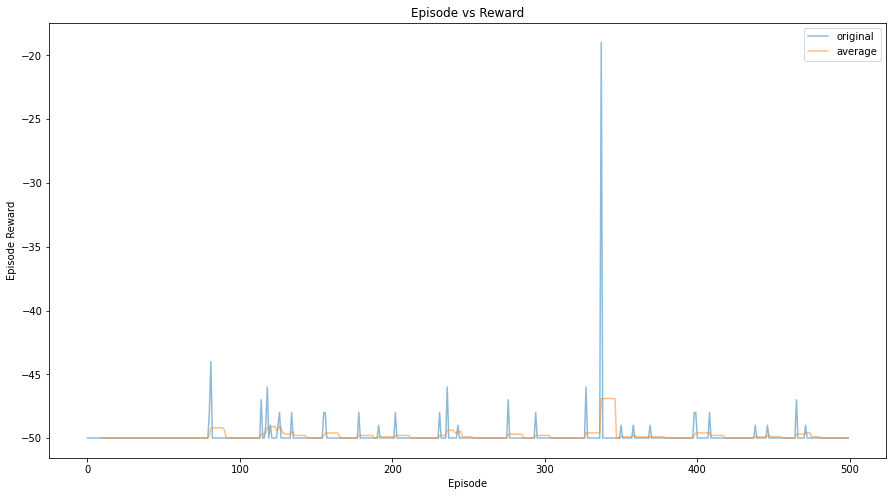

In [26]:
# plot stats
print(t2-t1)
def get_running_stat(stat, stat_len):
    cum_sum = np.cumsum(np.insert(stat, 0, 0)) 
    return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len

episode, r, l = np.array(stats_rewards_list).T
cum_r = get_running_stat(r, 10)
cum_l = get_running_stat(l, 10)

# plot rewards
plt.figure(figsize=(15,8))
plt.plot(episode, r, alpha = 0.5, label='original')
plt.plot(episode[-len(cum_r):], cum_r, alpha = 0.5, label='average')
plt.title('Episode vs Reward')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Episode Reward')
i+=1
plt.savefig('image'+str(i)+'.png')